In [1]:
# Import SQL alchemy dependencies
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, inspect

# Import other dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

### Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine to the hawaii database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Create automap base
Base = automap_base()

# Prepare base to reflect tables
Base.prepare(engine, reflect=True)

In [4]:
# Print classes from base
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save a reference to the classes
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# Begin a session
session = Session(engine)

### Exploratory Precipitation Analysis

In [7]:
# Use inspector to see the class/table names (same as keys)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Use inspector to see the column names for measurement
columns_measurement = inspector.get_columns('measurement')

for c in columns_measurement:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# See the first five rows of data in measurment
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Find the most recent date in measurement
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [12]:
sel = [Measurement.date,
       func.sum(Measurement.prcp)
]

In [13]:
# Retrieve the last 12 months of precipitation data
twelve_months = session.query(*sel).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).group_by(Measurement.date).all()


In [28]:
# Load the query results into a DataFrame
measurement_df = pd.DataFrame(twelve_months, columns = ["date", "precipitation"])
measurement_df

,date,precipitation
0,2016-08-23,2.71
1,2016-08-24,9.33
2,2016-08-25,0.54
3,2016-08-26,0.10
4,2016-08-27,0.32
...,...,...
361,2017-08-19,0.09
362,2017-08-20,0.01
363,2017-08-21,0.58
364,2017-08-22,0.50


In [29]:
date_count = measurement_df['date'].count()
date_count

366

In [31]:
divided = date_count / 12
divided

30.5

In [19]:
# Find date labels for dates every 31 days
date_labels = []
date = dt.date(2016,8,23)
start_date_str = date.strftime("%Y-%m-%d")
date_labels.append(start_date_str)

for x in range(0,11):
    date = date + dt.timedelta(days=31)
    date_str = date.strftime("%Y-%m-%d")
    date_labels.append(date_str)

In [20]:
date_labels

['2016-08-23',
 '2016-09-23',
 '2016-10-24',
 '2016-11-24',
 '2016-12-25',
 '2017-01-25',
 '2017-02-25',
 '2017-03-28',
 '2017-04-28',
 '2017-05-29',
 '2017-06-29',
 '2017-07-30']

In [21]:
measurement_df.set_index("date", inplace=True)
measurement_df.sort_values("date")

,precipitation
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


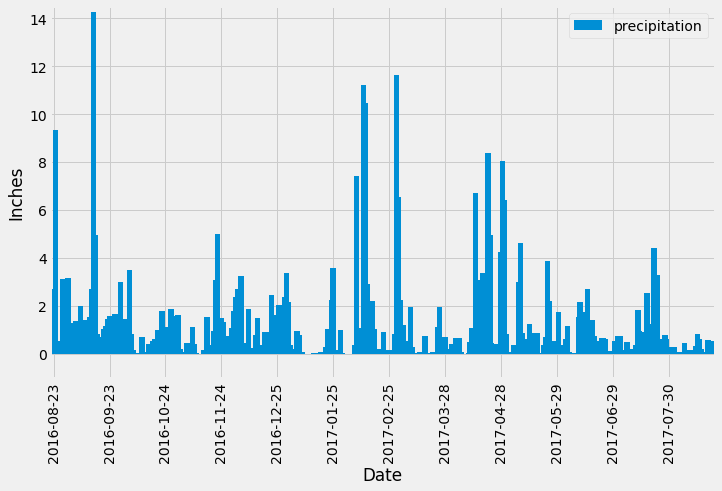

In [35]:
# Plot the results using the DataFrame plot method
ax = measurement_df.plot(rot = 90, kind="bar", figsize=(10, 6), width=3)
plt.tight_layout()
plt.xticks(np.arange(0,date_count,31), date_labels)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.ylim(-1,14.5)
#plt.title("Precipitation in the Last 12 Months")
plt.show()

In [37]:
# Summary statistics
measurement_df["precipitation"].describe()

count    366.000000
mean       0.978907
std        1.776349
min        0.000000
25%        0.052500
50%        0.405000
75%        1.087500
max       14.280000
Name: precipitation, dtype: float64

In [47]:
# Calculate stats for table
max_prcp = measurement_df["precipitation"].max()
min_prcp = measurement_df["precipitation"].min()
std_prcp = measurement_df["precipitation"].std()
avg_prcp = measurement_df["precipitation"].mean()
median_prcp = measurement_df["precipitation"].median()

In [48]:
# Stats Table
stats_table = pd.DataFrame({
    "Mean": avg_prcp,
    "Max": max_prcp,
    "Min": min_prcp,
    "Standard Dev": std_prcp,
    "Median": median_prcp
}, index=[0])

stats_table

,Mean,Max,Min,Standard Dev,Median
0,0.978907,14.28,0.0,1.776349,0.405


### Exploratory Station Analysis

In [9]:
# Use inspector to see the column names for station
columns_station = inspector.get_columns('station')

for c in columns_station:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [51]:
# See the rows of data in station
engine.execute("SELECT * FROM station").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [50]:
# Query to calculate the total number of stations
session.query(func.count(Station.station)).all()

[(9,)]

In [72]:
# Query to find the most active stations 
sel = [Station.id,
    Station.name,
    func.count(Measurement.id)
]

session.query(*sel).filter(Station.station == Measurement.station).\
    group_by(Station.id).order_by(func.count(Measurement.id).desc()).all()

[(7, 'WAIHEE 837.5, HI US', 2772),
 (1, 'WAIKIKI 717.2, HI US', 2724),
 (2, 'KANEOHE 838.1, HI US', 2709),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 (9, 'MANOA LYON ARBO 785.2, HI US', 2612),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 (4, 'PEARL CITY, HI US', 1372),
 (5, 'UPPER WAHIAWA 874.3, HI US', 511)]

In [ ]:
# List the stations and observation counts in desc order

In [ ]:
# Query to retrieve last 12 months of temperature observation data

In [ ]:
# Close the session
session.close()